# Analyse von Arxiv: Strukturierte und unstrukturierte Daten

Dieses Jupyter Notebook stellt die Prüfungsaufgabe des Moduls "Maschinelles Lernen" (ROB60) der Akad University dar.

## Einführung

Die Aufgabenstellung dieser Prüfung ist es Artikel zu einem selbstgewählten Thema der Webseite [Arxiv](https://arxiv.org/) zu analysieren.
Im ersten Schritt wird ein Histogramm der über die Anzahl der Artikel pro Autor erstellt. Im Weiteren wird eine deskriptive Analyse für die verschiedenen Jahr durchgeführt.
Das Ziel ist zu eruieren, ob sich über die Jahre gewisse Parameter oder Korrelationen verändert haben. Dies könnte beispielsweise die Anzahl der veröffentlichten Artikel pro Autor
oder die Anzahl an Autoren sein. Darüber hinaus wird eine Textanalyse durchgeführt. Diese Analyse wird anhand des Abstracts der Artikel durchgeführt.
Diese Aufgaben werden sich am CRISP DM Standard orientieren und die folgenden Punkte beinhalten:

1. Verstehen der Daten (Data Understanding)
2. Datenvorbereitung (Data Preparation)
3. Modellierung (Modeling)
4. Auswertung (Evaluation)

## Extraktion und Verstehen der Daten (Data Understanding)

Für die Extraktion der Daten findet mittels der Web-API der Platform von Arxiv statt. Es wird das exemplarische Stichwort "Deep Reinforcement Learning" gewählt.
Um eine möglichst aussagekräftige Analyse durchführen zu können, werden Artikel für die Jahre 2017-2021 heruntergeladen. Pro Jahr sollen 200 Artikel heruntergeladen und in die
Analyse miteinbezogen werden.

### Beschreibung der Datenquelle und des Codes zur Extraktion

Die Platform Arxiv bietet eine Web-Api an, um Metadaten der Artikel zu extrahieren. Hierbei wird eine Anfrage an den Server mittels des Protokolls gesendet.
Die Parametrisierung findet mittels der URL statt. Für die Extraktion eben jener Daten wird das Paket `arxiv` verwendet. Es bietet eine API zur Parametrisierung der Anfrage an.
Im folgenden Code wird zunächst ein leeres Array für die extrahierten Artikel angelegt. Darüber hinaus werden die Jahreszahlen in einem Array definiert und die maximale Anzahl an Artikeln
pro Jahr. Aufgrund einer Limitation der Api, die nur maximal 200 Artikel pro Anfrage zurückliefert, werden mehrere Iterationen durchgeführt. Für jedes Jahr wird eine Suche durchgeführt und
die Metadaten Titel, Autoren, Zusammenfassung und Veröffentlichungsdatum der einzelnen Artikel einem Array hinzugefügt. Zuletzt werden die Artikel in einem Dataframe gespeichert.


In [ ]:
import arxiv
import pandas as pd
from arxiv import Search

# Variables
articles = []
years = [2018, 2019, 2020, 2021]
number_of_articles = 200
client = arxiv.Client()

for year in years:

    # Define search query
    search_query = f"Deep Reinforcement Learning AND submittedDate:[{year}01010000 TO {year}12312359]"

    # Search for the articles
    search = Search(
        query=search_query,
        max_results=number_of_articles,
    )

    # Request the articles
    results = client.results(search)

    # Save retrieved data in array
    for result in results:
        article = {
            "Title": result.title,
            "Authors": [str(author) for author in result.authors],
            "Abstract": result.summary,
            "PublishedDate": result.published.date(),
        }
        articles.append(article)

# Save articles in data frame
df = pd.DataFrame(articles)

# Print types and head
print(f"Types of the data frame \n {df.dtypes}")
print(f"The head of the data frame \n {df.head()}")

## Vorbereiten der Daten (Data Preparation)

Im folgenden Abschnitt wird eine Aufbereitung der Daten vorgenommen. Dies ist ein essenzieller Teil jedes Datenprojektes. Je besser die Daten aufbereitet wurden, desto aussagekräftiger
sind die Ergebnisse der nachfolgenden Analyse des Datenbestands. Sie wird unmittelbar nach der Extraktion der Daten vorgenommen. Hierzu gehören üblicherweise folgende Schritte:

1. Umbenennung der Spalten für eine aussagekräftigere Darstellung der Daten und des verarbeitenden Codes.
2. Entfernung irrelevanter Spalten für die weitere Verarbeitung
3. Entfernung von Duplikaten und Zeilen mit Null-Werten.
4. Entfernung von Ausreißern

Aus der Codezelle zur Datenextraktion geht hervor, dass eine Selektion und Benennung der Spalten für das DataFrame bereits stattgefunden hat. Die ersten beiden Schritte wurden somit durchgeführt.
Eine Bereinigung von Ausreißern findet in diesem DataFrame nicht statt, da außer dem Veröffentlichungsdatum keine numerischen Werte enthalten sind. Eine Bereinigung von Ausreißern wäre hier auch nicht nötig,
da die Jahreszahlen explizit bei der Abfrage parametrisiert wurden.

In der folgenden Codezelle wird nach der Extraktion eine Bereinigung der Werte hinsichtlich vorkommender Null-Werte vorgenommen. Hierzu wird die Methode `dropna` auf das DataFrame angewendet.
Zudem wird die Spalte `Authors` expandiert. Viele Artikel haben mehrere Autoren. Diese wurden im DataFrame als `list` gespeichert. Damit die Analyse hinsichtlich der Anzahl veröffentlichter Publikationen pro Autor durchgeführt werden kann,
ist es sinnvoll mit der Methode `explode` eine Expansion durchzuführen. Diese Operation wird nachfolgend exemplarisch dargestellt.

Ausgehend von der folgenden Tabelle in denen exemplarisch zwei Publikationen von mehreren Autoren verfasst wurden, sollen für jeden Autor weitere Datensätze erzeugt werden.
Die anderen Werte sollen dabei nicht verändert werden

| Titel   | Autoren            | Veröffentlichungsdatum |
|---------|--------------------|------------------------|
| Titel A | [Autor A, Autor B] | 2018                   |
| Titel B | [Autor B, Autor C] | 2019                   |

Das Ergebnis der Methode `explode` würde wie folgt aussehen:

| Titel   | Autoren | Veröffentlichungsdatum |
|---------|---------|------------------------|
| Titel A | Autor A | 2018                   |
| Titel A | Autor B | 2018                   |
| Titel B | Autor B | 2019                   |
| Titel B | Autor C | 2019                   |

Mithilfe der zweiten Tabelle kann nun eine Quantifizierung der Autoren pro Publikation durchgeführt werden.
Hierzu wird über die definierten Jahre iteriert und das DataFrame für das entsprechende Jahr gefiltert. Dies wird mit der `isin`-Methode getan.
Die zehn Autoren mit den meisten geschrieben Publikationen des entsprechenden Jahres werden auf der Spalte mit der Methode `value_counts` erhoben.
Eine Limitierung auf die 10 Autoren mit den meisten Publikation wird mit der Methode `head` durchgeführt.
Anschließend wird das Histogramm dargestellt. Die Autoren werden auf der x-Achse dargestellt. Für jeden Autor gibt es einen Balken.
Auf der y-Achse erweist sich eine Skala von 0 bis 10 als sinnvoll. Die Schrittweite beträgt 1.

In [ ]:
import matplotlib.pyplot as plt
from extraction import extract_data_from_arxiv
import pandas as pd

# Extract data from API
df = extract_data_from_arxiv()

# Ensure PublishedDate is in datetime format
df["PublishedDate"] = pd.to_datetime(df["PublishedDate"], errors="coerce")

# Drop rows with null values in Authors or PublishedDate
df = df.dropna(subset=["Authors", "PublishedDate"])

# Expand the possible multiple authors of a paper to an own entry for each author
df = df.explode(column="Authors")

# Define the years to analyze
years = range(2018, 2022)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Count authors for the selected year and take the top 10 authors with the most publications
    top_author_counts = year_filtered_df["Authors"].value_counts().head(10)

    # Plot the histogram
    top_author_counts.plot(kind="bar")
    plt.title(f"Top 10 authors for {year}")
    plt.xlabel("Author")
    plt.ylabel("Count")
    plt.yticks(range(0, max(top_author_counts.max() + 1, 11), 1))
    plt.show()

## Darstellung der Artikel pro Monat in einem Histogramm

Nach der Vorbereitung der Daten geht es weiter mit der explorativen Analyse basierend auf den extrahierten und präparierten Daten. Basierend auf dem CRISP-DM Standard, ist die explorative Analyse dem vierten Schritt "Modeling" zuzuordnen.
Ziel dieses Schrittes eine statistische Methode für die Gewinnung von Informationen aus den Daten auszuwählen. In Verbindung mit dem ersten Schritt "Business Understanding" des Standards CRISP-DM erfolgt eine Bewertung des definierten Testmodells gegenüber den definierten analytischen Ziele des Data-Mining-Projekts. Der Schritt "Business Understanding" wird in dieser Ausarbeitung keine besondere Rolle spielen. Es sei der Vollständigkeit halber jedoch erwähnt.

Ziel der folgenden explorativen Analyse ist die Darstellung der Anzahl der veröffentlichten Artikel pro Monat für die Jahre 2018-2022. Ziel dieser Analyse ist Gewinnung der Information, ob in einem bestimmten Zeitraum Häufungen für die Veröffentlichung auftreten und wenn ja, ob diese wiederkehrend von Jahr zu Jahr auftreten. Als analytische Methode wurde hierfür ein Histogramm gewählt. Das Balkendiagramm zeigt auf der x-Achse die Monate Januar-Dezember an und auf der y-Achse die Anzahl der veröffentlichten Artikel.

Für die Darstellung der Monate wird das Paket `calendar` verwendet. Die Sequence `month_name` wird iteriert und ihre Namen gemäß der bekannten Reihenfolge der Monate geordnet. Anschließend wird für jedes Jahr die Einträge des DataFrame zum entsprechenden Jahr in einem DataFrame namens `year_filtered_df` gespeichert. Sollten keine Daten für das jeweilige Jahr vorhanden sein, wird die aktuelle Iteration übersprungen. Sind Daten vorhanden, wird das DataFrame basierend auf der Spalte `PublishedDate` gruppiert. Dies geschieht mit der zuvor erwähnten Sequence `month_name`. Die gruppierten Einträge werden gezählt und mit der Methode `reindex` werden die gezählten Einträge den Monaten zugeordnet. Aus dieser Operation resultiert die Liste `articles_per_month`. Anschließend werden die Daten visualisiert.

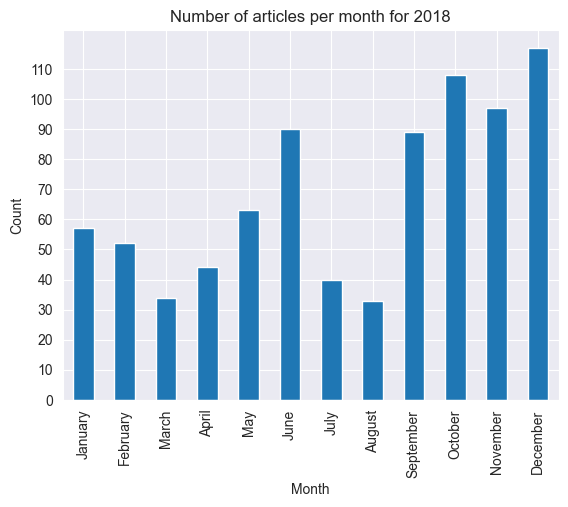

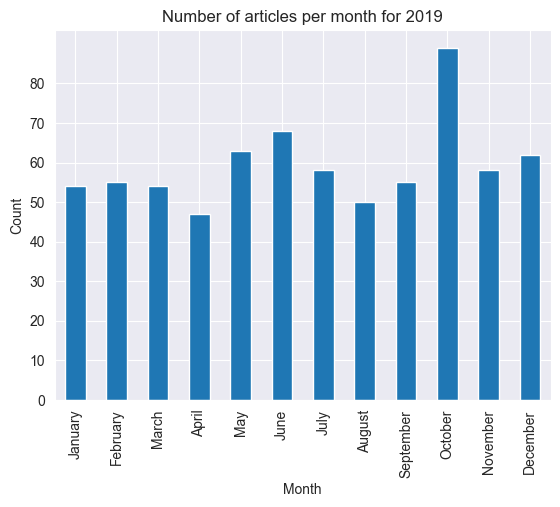

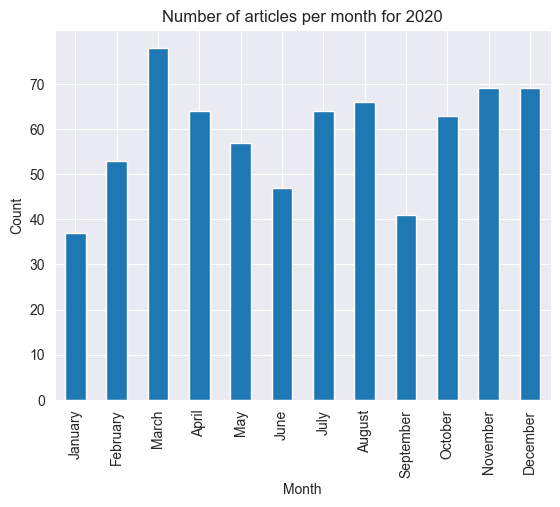

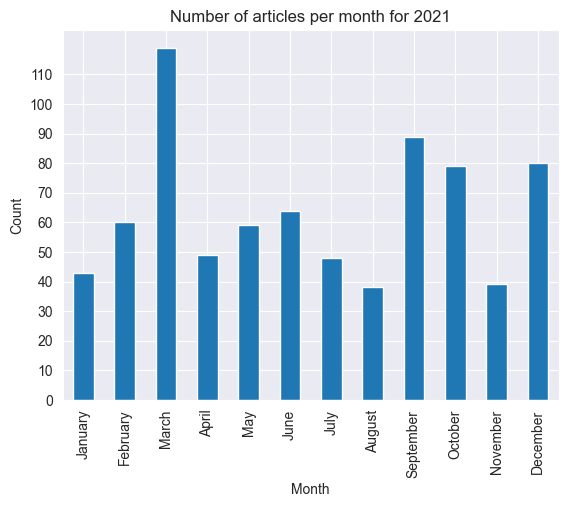

In [4]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of articles per month and sort the series by the index
    articles_per_month = (year_filtered_df["PublishedDate"].groupby(year_filtered_df["PublishedDate"].dt.month_name())
                          .count()
                          .reindex(month_order, fill_value=0))

    # Plot the histogram
    articles_per_month.plot(kind="bar")
    plt.title(f"Number of articles per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(articles_per_month.max() + 1, 11), 10))
    plt.show()

## Darstellung der Anzahl der Autoren pro Monat in einem Histogramm

Als weitere Analyse im Rahmen des Schritts "Modeling" des Standards CRISP-DM, wird untersucht, wie viele Autoren pro Monat Artikel veröffentlicht haben. Als statistische Analyse wird ebenfalls ein Histogramm in Erwägung gezogen, da diese Methode die Relation zwischen der Anzahl der Autoren und den Monaten am besten darstellt. Ähnlich zu vorherigen Zelle wird auch hier das Paket `calendar` für die Zuordnung der Daten zu den Monaten genutzt. Nach der Filterung der Daten nach dem zu analysierenden Jahr wird eine Gruppierung nach den Monaten durchgeführt. Im Weiteren wird auf die Spalte "Authors" zugegriffen und die Elemente gezählt. Die Methode `nunique` zählt dabei eineindeutigen Elemente, sodass die Autoren nicht mehrmals gezählt werden. Dies würde das Ergebnis in jeder Hinsicht verfälschen. In Bezug auf diese Analyse kann `nunique` als Umkehroperation zur `explode`-Methode aus dem Kapitel "Data Preparation" verstanden werden. Die Methode `reindex` ordnet die resultierende Anzahl der Autoren den Monaten. Zum Schluss werden die Histogramme für jedes Jahr ausgegeben.

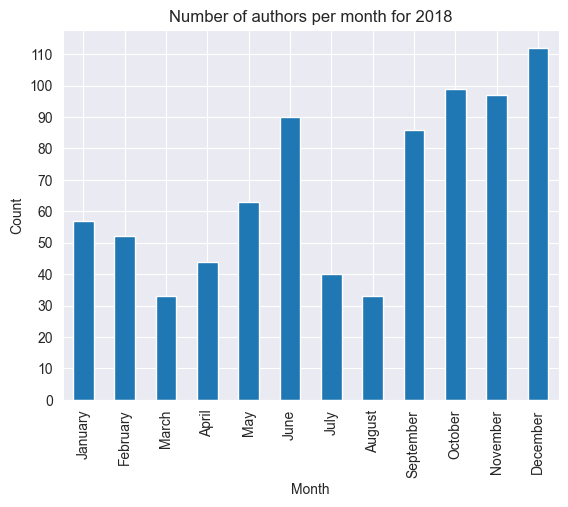

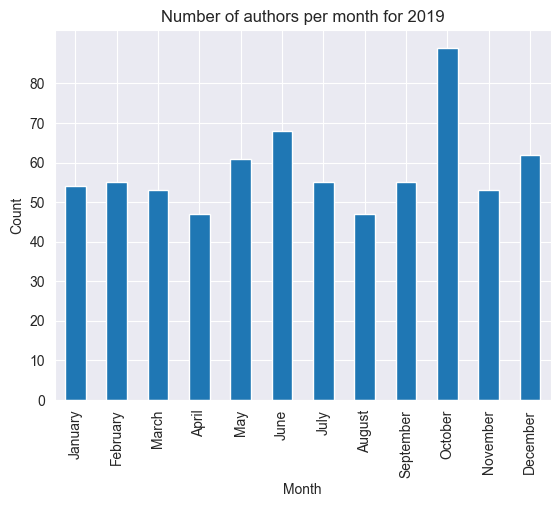

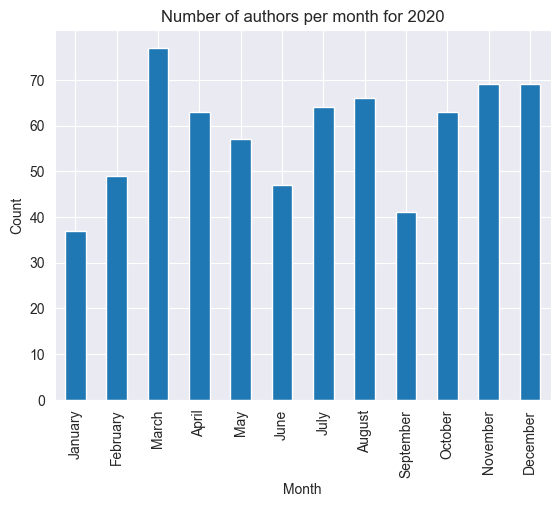

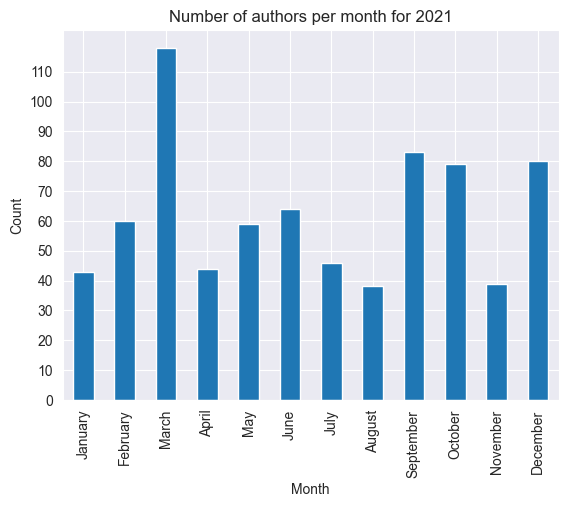

In [5]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of authors per month and sort the series by the index
    authors_per_month = (year_filtered_df.groupby(year_filtered_df["PublishedDate"].dt.month_name())["Authors"]
                         .nunique()
                         .reindex(month_order, fill_value=0))

    # Plot the histogram
    authors_per_month.plot(kind="bar")
    plt.title(f"Number of authors per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(authors_per_month.max() + 1, 11), 10))
    plt.show()

## Analyse der Keywords des Titels in einer Wordcloud

Die folgende Codezeile zeigt eine Analyse wichtiger Schlüsselwörter des Titels auf. Ziel dieser Analyse ist es, die wichtigsten Themen für aus den Titeln der Artikel für jedes Jahr zu ermitteln und diese in einer Wordcloud darzustellen. Eine ist ein Bild mit den entsprechenden Wörtern, wobei die Schriftgröße der Wörter größer ist, je mehr die Wörter in den Titeln vorkommen. Als Alternative könnte auch ein Balkendiagramm genutzt werden, welches die Wörter auf der x-Ache darstellt und ihre Anzahl Vorkommen auf der y-Achse. Für das folgende Beispiel wird die Wordcloud genutzt.

### Darstellung einer Wordcloud

Basierend auf der Extraktion der Titel für jedes Jahr wird eine Textbereinigung durchgeführt. Ziel ist es sogenannte Stopwords zu entfernen. Dies sind Wörter wie Konjunktionen (z.B. und, oder, etc.) oder Präpositionen (z.B. in, auf, am, etc.). Solche Wörter sollen nicht Teil der Wordcloud sein, da sie keinen Informationsgehalt hinsichtlich der Analyse bieten. Für diesen Teil der Analyse wird eine Funktion `clean_text` definiert. Sie ersetzt alle Großbuchstaben durch Kleinbuchstaben und entfernt Sonderzeichen wie Fragezeichen oder Punkte. Diese geben ebenfalls keinen Aufschluss über die inhaltliche Zusammensetzung der Titel der Artikel. Diese Funktion wird auf alle Titel der Artikel angewendet. Anschließend werden die Stopwords entfernt. Da die Liste der Stopwords sehr groß ist, wird hierfür eine Bibliothek zur Hilfe gezogen. Die Stopwords werden für die englische Sprache ebenfalls von der Bibliothek `wordcloud` mitgeliefert. Sie werden in einem `set[str]` gespeichert. Als weiteren Schritt werden die Wordcloud initialisiert. Neben der Hintergrundfarbe werden die Stopwords als Parameter angegeben und die maximale Anzahl an Wörtern die berücksichtigt werden soll. Dies wird mit 100 parametrisiert, um die wichtigsten Begriffe darzustellen. Bei höheren Werten, würde mehr Nuancen beinhaltet sein, jedoch würde die Wortwolke auch potenziell unübersichtlich werden. Für die Analyse von kürzeren Titeln reicht die Anzahl von 100 Wörtern aus. Die maximale Schriftgröße wird mit 100 angegeben. Dieser Wert wird mit 100 sehr groß angegeben, sodass die Gewichtung der einzelnen Wörter stärker ist und ein optisch gut erkennbarer Unterschied in der Wordcloud zu sehen ist. Mit dem letzten numerischen Parameter wird ein `random_state` angegeben. Der Wert dieses Parameters gibt Startwert für den Algorithmus vor, der die Wörter im resultierenden Bild platziert. Damit wird die Platzierung der Wörter in der Wordcloud deterministisch. Das bedeutet, dass bei gleicher Eingabe des Parameters, ist auch die Anordnung der Wörter immer gleich. Der exakte Wert ist hierbei unerheblich. Durch Probieren kann die beste Platzierung der Wörter gefunden werden. Oftmals wird die Zahl 42 als Standardwert genutzt.

### Analyse mit Hilfe eines Bag-of-words-Modells

Eine weitere Methode mehr über die inhaltliche Zusammensetzung der Titel zu erfahren ist die Nutzung eines Bag-of-Words-Modells. Beim Bag-of-words-Modell wird der Text in seine Wörter unterteilt und jedes Wort zusammen mit der Anzahl seiner Vorkommen in einem sogenannten Vokabular abgespeichert. Nachfolgend soll ein einfaches Beispiel dargestellt werden.

1. Ich mag Hunde
2. Sie mag Katzen
3. Wir mögen Hunde und Katzen

Aus diesen drei Katzen kann das folgende Vokabular ermittelt werden: `["Ich", "mag", "Hunde", "Sie", "Katzen", "Wir", "mögen", "und"]`. Bezieht man eine Lemmatisierung mit ein so können die Wörter "mögen" und "mag" als ein Token betrachtet werden, da sie vom gleichen Verb abstammen, jedoch unterschiedlich konjugiert sind. Fügt man den Wörtern die Anzahl ihrer Vorkommen hinzu, erhält man folgende Tabelle:

| Wort   | Anzahl |
|--------|--------|
| Ich    | 1      |
| mag    | 1      |
| Hunde  | 2      |
| Sie    | 1      |
| Katzen | 2      |
| Wir    | 1      |
| mögen  | 1      |
| und    | 1      |

Das Bag-of-words-Modell wird mithilfe der Klasse `CountVectorizer` erzeugt. Die Parameter `min_df` und `max_df` geben an, dass Wörter die in weniger als zwei Artikeln und mehr als 95 Artikeln auftauchen, ignoriert werden. Dies hat den Hintergrund, dass irrelevante Wörter nicht in die Analyse miteinbezogen werden. Dies können Wörter sein, die kaum vorkommen oder auch Stopwörter wie Präpositionen oder Konjunktionen. Der Parameter `max_features` bezieht sich auf die Anzahl der Wörter, die Teil des Bag-of-words-modells sein sollen. Der letzte Parameter gibt die Sprache der Stopwörter an. Das Modell wird mit der Methode `fit_transform`  auf die Artikel angewendet. Die Methode `get_feature_names_out` gibt eine Liste der Wörter des Bag-of-words-modells zurück. Die Variable `transformed_vectorizer` beinhaltet das gesamte Bag-of-words-Modell.

### Analyse des Bag-of-words-Modells mit dem LatentDirichletAllocation-Algorithmus

Auf diesem Modell wird der LatentDirichletAllocation (LDA) Algorithmus angewendet, um herauszufinden, welche Themen für das entsprechende Jahr dominierend in den Titeln der Artikel vorkommen. Der Algorithmus eignet sich besonders gut, um Themen aus den Bag-of-words Modellen zu identifizieren. Hierzu prüft der Algorithmus die Existenz der Wörter in den einzelnen Modellen und versucht Korrelationen von ähnlichen Wörtern in den Dokumenten zu finden und diese entsprechend zu identifizieren. Zum Beispiel kann in einem Zeitungsartikel das Wort "Geld" vorkommen. Je nach dem in welchem Kontext sich dieses Wort befindet, ist es einer anderen Kategorie zuzuordnen. Taucht das Wort oft mit "Aktien" auf, wird der Artikel eher zum Wirtschaftsteil der Zeitung gezählt. Befindet sich das Wort "Geld" eher im Zusammenhang mit dem Wort "Gesetz" oder "Regierung", ist der Artikel eher der Kategorie "Politik" zuzuordnen. Für die Verwendung des LDA-Algorithmus wird die Klasse `LatentDirichletAllocation` entsprechend parametrisiert. Der Parameter `n_components` gibt an, dass 10 Themen aus den Artikeln extrahiert werden sollen. Dies dürfte einen guten Überblick über die inhaltliche Zusammensetzung der recht kurzen Titel geben. Eine Analyse längerer Text erfordert eine größere Anzahl an Themen, um mehr Nuancen zu erfassen. Mit dem Parameter `max_iter` wird die Anzahl der Trainingsdurchläufe angegeben. Für kleinere Datenmengen unter 1000 Datensätzen, sind 5 bis 10 Durchläufe ausreichend. Je höher die Zahl, desto genauer die Themenfindung. Die Lernmethode wird auf `online` gesetzt, dies ist bei einer größeren Anzahl an Dokumenten die schnellere Art, da die Dokumente schrittweite verarbeitet werden und nicht alles auf einmal. Mit dem Parameter `learning_offset` wird ein Stabilisierungsfaktor für das Training angegeben. Es wird eine Gewichtung angegeben, die frühere Durchläufe höher gewichtet, als spätere. Der letzte Parameter `random_state` sorgt ähnlich wie bei der Wordcloud für eine Reproduzierbarkeit des Algorithmus. Zuletzt werden die Themen ausgegeben.

===================================================   2018   ===================================================


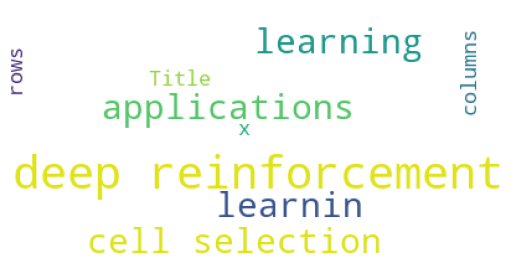

Thema: 0
['td', 'differencing', 'role', 'improving', 'search']
Thema: 1
['learning', 'communications', 'adversarial', 'generating', 'programs']
Thema: 2
['speech', 'open', 'horizon', 'applied', 'platform']
Thema: 3
['network', 'modular', 'ii', 'starcraft', 'architecture']
Thema: 4
['learning', 'reinforcement', 'deep', 'control', 'based']
Thema: 5
['reinforcement', 'behaviors', 'learning', 'dynamic', 'using']
Thema: 6
['robotic', 'simulation', 'evaluation', 'simulated', 'methods']
Thema: 7
['learning', 'reinforcement', 'deep', 'optimization', 'navigation']
Thema: 8
['model', 'hydrophobicpolar', 'scratch', 'foldingzero', 'protein']
Thema: 9
['mobile', 'sparse', 'cell', 'crowdsensing', 'selection']
===================================================   2019   ===================================================


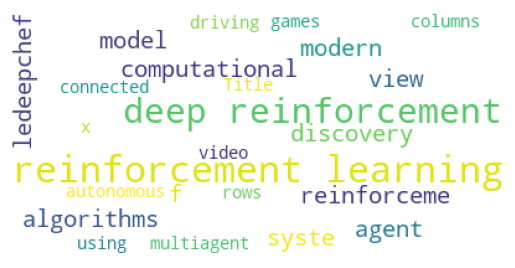

Thema: 0
['machine', 'higherorder', 'environment', 'holist', 'learning']
Thema: 1
['learning', 'reinforcement', 'deep', 'multiagent', 'games']
Thema: 2
['probabilistic', 'variables', 'context', 'metareinforcement', 'offpolicy']
Thema: 3
['latent', 'improved', 'trajectory', 'exploration', 'gradient']
Thema: 4
['learning', 'reinforcement', 'deep', 'using', 'control']
Thema: 5
['structured', 'dialogue', 'universal', 'agentgraph', 'adaptivity']
Thema: 6
['transformer', 'logic', 'asynchronous', 'advantage', 'algorithm']
Thema: 7
['adversarial', 'risk', 'averse', 'robust', 'variational']
Thema: 8
['deep', 'evaluation', 'quantum', 'study', 'learningbased']
Thema: 9
['knowledge', 'safer', 'embedding', 'faster', 'highlevel']
===================================================   2020   ===================================================


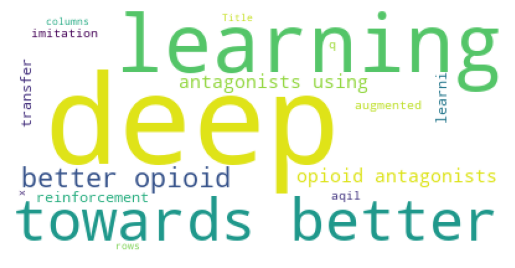

Thema: 0
['derrich', 'protection', 'learningbasedrobust', 'grids', 'distribution']
Thema: 1
['learning', 'reinforcement', 'metalearned', 'instincts', 'readmission']
Thema: 2
['qlearning', 'insights', 'theoretical', 'asymptotic', 'dqn']
Thema: 3
['learning', 'reinforcement', 'deep', 'using', 'control']
Thema: 4
['networks', 'neuromorphic', 'spiking', 'energyefficient', 'hardware']
Thema: 5
['learning', 'deep', 'theory', 'systems', 'presence']
Thema: 6
['interactive', 'environment', 'feedback', 'humanrobot', 'following']
Thema: 7
['babyai', 'human', 'text', 'instructionfollowing', 'transferlearning']
Thema: 8
['partially', 'communication', 'limited', 'environments', 'observable']
Thema: 9
['learning', 'reinforcement', 'review', 'efficient', 'deep']
===================================================   2021   ===================================================


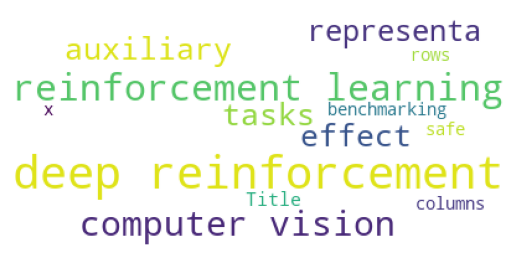

Thema: 0
['learning', 'reinforcement', 'deep', 'multiagent', 'benchmark']
Thema: 1
['algorithms', 'quantitative', 'trading', 'ppo', 'parallelnetwork']
Thema: 2
['deep', 'learning', 'reinforcement', 'problem', 'classification']
Thema: 3
['learning', 'reinforcement', 'deep', 'survey', 'using']
Thema: 4
['attacks', 'membership', 'correlated', 'inference', 'temporally']
Thema: 5
['pseudoactions', 'repeats', 'frames', 'action', 'skipped']
Thema: 6
['learning', 'reinforcement', 'deep', 'using', 'data']
Thema: 7
['formed', 'packetrouting', 'adhoc', 'aeronautical', 'passenger']
Thema: 8
['auxiliary', 'secure', 'adhoc', 'wiretap', 'dream']
Thema: 9
['deployment', 'avoidance', 'deepreinforcementlearningbased', 'autonomous', 'arenarosnav']


In [8]:
import pandas as pd
import re as regex
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define the relevant years for the analysis
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)


# Clean the titles from special chars and lower the text
def clean_text(text):
    text = text.lower()
    text = regex.sub(r'\[.*?\]', '', text)
    text = regex.sub(r'[%s]' % regex.escape(string.punctuation), '', text)
    text = regex.sub(r'\w*\d\w*', '', text)
    return text

for year in years:

    # Add delimiter to separate the years in the output
    print(f"===================================================   {year}   ===================================================")

    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Clean the title from special characters
    cleaned_df = pd.DataFrame(year_filtered_df["Title"].apply(clean_text))

    # Set the stop words
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=100,
        max_font_size=100,
        random_state=100,
    ).generate(str(cleaned_df))

    # Print the wordcloud
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    # Identify topics in the titles of the articles using the Latent Dirichlet allocation
    vectorizer = CountVectorizer(
        min_df=2,
        max_df=0.95,
        max_features=1000,
        stop_words='english',
    )
    transformed_vectorizer = vectorizer.fit_transform(cleaned_df["Title"])
    feature_names = vectorizer.get_feature_names_out()

    # Tries to create combinations from the titles regarding multiple topics. The hyperparameters are the number of components,
    # the maximum iterations and the learning method
    lda = LatentDirichletAllocation(
        n_components=10,
        max_iter=5,
        learning_method='online',
        learning_offset=50,
        random_state=0,
    ).fit(transformed_vectorizer)

    # Print topics
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Thema: {topic_idx}")
        print([feature_names[i] for i in topic.argsort()[:-5 - 1:-1]])

## Darstellung der Länge des Abstracts in einem Boxplot

In der folgenden Zelle wird ein Boxplot zur Darstellung der Längen der Abstracts über alle Jahre dargestellt. Das Boxplot eignet sich besonders gut zur Darstellung der Verteilung einer numerischen Größe. Hierfür wird das DataFrame zunächst nach dem Datum sortiert, sodass eine chronologische Darstellung der Verteilung erfolgen kann. Anschließend wird die Länge der Abstracts ohne Leerzeichen ermittelt und in der Spalte `abstract_length` gespeichert. Im letzten Schritt wird das Boxplot basierend auf der berechneten Abstract-Länge ausgegeben.

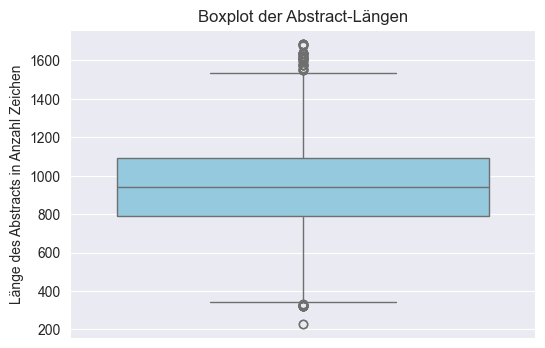

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)

# Define a function that removes the spaces from the abstract and calculates the length
def calculate_trimmed_length(text: str):
    return len(text.replace(" ", ""))

# Sort the dataframe by the values
df = df.sort_values(by=["PublishedDate"])

# Calculate the length of the abstract
df["abstract_length"] = df["Abstract"].apply(calculate_trimmed_length)

# Print boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(y=df["abstract_length"], color="skyblue")
plt.ylabel("Länge des Abstracts in Anzahl Zeichen")
plt.title("Boxplot der Abstract-Längen")
plt.show()

## Beschreibung der Ergebnisse der explorativen Analyse und Ausblick

Zum Abschluss der Analyse der strukturierten Daten sollen die gewonnenen Informationen dargestellt werden und die eingesetzten statischen Methoden bewertet werden. Dies entspricht dem Schritt "Evaluation" des CRISP-DM Standard.
Ein weiteres Ziel dieses Schrittes ist die Festlegung weiterer Schritte für weitergehende Analysen.

Die erste Analyse zeigt ein Histogramm mit der Anzahl der veröffentlichten Artikel pro Monat für jedes Jahr. Die Histogramme zeigen, dass eine Häufung der veröffentlichten Artikel in den Monaten Oktober, November und Dezember auftaucht.
In den Jahren 2020 und 2021 zeigt auch der März eine Häufung veröffentlichter Artikel. Die anderen Zeiträumen zeigen ein Schwanken, welches keinen wesentlichen Informationsgehalt bietet. Die anschließende Analyse der Anzahl von Autoren pro Monat zeigt ein ähnliches Bild. Dies ist keine große Überraschung, da die Anzahl der veröffentlichten Artikel mit der Anzahl der Autoren pro Monat korreliert. Diese Korrelation zeigt auch, dass die Artikel von verschiedenen Autoren sind, da eine Häufung von veröffentlichten Artikeln eines einzelnen Autors eine hohe Anzahl von Artikeln bei gleichzeitig niedriger Anzahl von Autoren pro Monat zustande käme. Als Verbesserung könnten die Namen der Autoren angezeigt werden. Darüber hinaus wäre es interessant zu analysieren, in welchen Monaten die Autoren favorisiert veröffentlichen. Gibt es bestimmte Monate, in denen sich die Veröffentlichungen eines Autors häufen?

Weitergehend wurden die Keywords der Titel analysiert. Aufgrund der Themenwahl "Deep Reinforcement Learning" sind diese Themen in den Word clouds der vier Jahre stark vertreten. Im Jahr 2018 sind die Begriffe "Selection", "Cell" sehr stark vertreten. In den folgenden Jahren macht sich bemerkbar, dass 2019 Begriffe wie "driving" und "games" stark an Bedeutung gewonnen haben. Dies lässt auf die zunehmende Relevanz von autonomem Fahren deuten. Darüber hinaus ist scheinen auch Multiagentensysteme von Bedeutung zu sein. Dies wird im folgenden Jahr von dem Begriff "antagonist" bestärkt. Im Jahr 2021 ist der Begriff "computer vision" hervorgehoben. Dies deutet darauf hin, dass Reinforcement Learning verstärkt auch in der Bildverarbeitung eingesetzt wird. Als Verbesserung dieser Analyse ist der fehlende kontextuelle Bezug zu nennen. Mit einzelnen Begriffen, wie "Computer vision" kann kaum eine Aussage über den Inhalt oder die Veränderung der Themen über die Jahre getroffen werden.

In der letzten Analyse der strukturierten Daten wurde die durchschnittliche Länge der Abstracts ermittelt und in einem Boxplot dargestellt. Der Median des Boxplot liegt zwischen 900 und 1000 Zeichen pro Abstract.

## Analyse der häufigsten Wörter der Abstracts für jedes Jahr

Die folgende Codezelle zeigt eine Analyse der häufigsten Wörter der Abstracts für jedes Jahr. Auf Basis der Datenextraktion wir die Aufbereitung der Daten durchgeführt. Es gilt zu beachten, dass keine Expansion der Autoren-Spalte durch die Methode `explode` erfolgt. Dies würde beim Zählen der Wörter ein falsches Ergebnis liefern. Im Weiteren wird ein Sprachmodell mithilfe der Bibliothek `spacy` heruntergeladen. Dieses Modell beinhaltet die Stopwords für die englische Sprache und eine Funktion zur Lemmatisierung. Basierend darauf wird die Funktion `clean_text` definiert, welche die Bereinigung von Stopwords und die Lemmatisierung auf den Abstracts durchführt.

Im Weiteren wird über die zu analysierenden Jahre iteriert und das DataFrame nach dem entsprechenden Jahr gefiltert. Anschließend werden die Abstracts zu einer Zeichenkette zusammengefügt und als Liste einzelner Wörter in der Variablen `all_Words` gespeichert. Die Klasse `Counter` berechnet die Anzahl der Vorkommen jedes Wortes. Für eine übersichtliche Darstellung der Analyse werden nur die 10 meisten Wörter in die Analyse miteinbezogen. Die Wörter und die Anzahl ihrer Vorkommen werden in einem neuen DataFrame namens `word_df` gespeichert. Zum Abschluss wird ein Balkendiagramm ausgegeben, wobei auf der x-Achse die Frequenz des Wortes und auf der y-Achse die Wörter dargestellt werden.

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.cli import download
from extraction import extract_data_from_arxiv
from preparation import prepare_data
from collections import Counter

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=False)

# Download and load the language model for the stopwords removal and the lemmatization
download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

# Define a function to be applied on the Abstract column for the text preparation
def clean_text(text):
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(filtered_words)

# Apply the text preparation on the abstract column
df["Abstract"] = df["Abstract"].apply(clean_text)

# Iterate over years and create a bar chart for every year
for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Collect all words from the abstracts
    all_words = " ".join(year_filtered_df["Abstract"]).split()

    # Calculate the word frequency for every word and take the 10 most common words
    word_frequency = Counter(all_words)
    top_words = word_frequency.most_common(10)

    # Create a dataframe from the words and the frequencies
    word_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

    # Print the bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Frequency", y="Word", data=word_df)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top 10 most frequent words in abstracts in {year}")
    plt.show()

## Ermittlung von Themen der Abstracts für jedes Jahr

Diese Codezelle beschäftigt sich mit der Textanalyse auf Basis der unstrukturierten Daten der Abstracts. Die vorherige Codezelle hat gezeigt, dass eine reine Summierung der Vorkommen der Wörter nicht ausreicht, um inhaltliche Informationen über die Abstracts zu bekommen.

### Vektorisierung mithilfe des TF-IDF-Algorithmus

Hierzu wird nach der Datenextraktion und der Textbereinigung von Stopwords und der Lemmatisierung der TF-IDF-Algorithmus auf die Abstracts angewendet. Vereinfacht gesagt berechnet dieser Algorithmus eine Kennzahl der Aufschluss über die Relevanz eines Wortes im Text gibt. Hierzu geht der `TfidfVectorizer` wie folgt vor:

1. Es werden die Vorkommen aller Wörter gezählt.
2. Der Algorithmus bestimmt die Inverse Document Frequency (IDF). Sie gewichtet die Wörter entsprechend der Vorkommen über verschiedene Abstracts hinweg. In je mehr Abstracts das Wort vorkommt, desto niedriger die Gewichtung. Je seltener die Vorkommen des Wortes, desto höher ist die Gewichtung
3. Die Kennzahlen der beiden ersten Punkte werden multipliziert. Je wichtiger das Wort, desto größer der Wert des `TfidfVectorizers`.

### Ermittlung der optimalen Anzahl der Cluster




✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
===================================================   2018   ===================================================


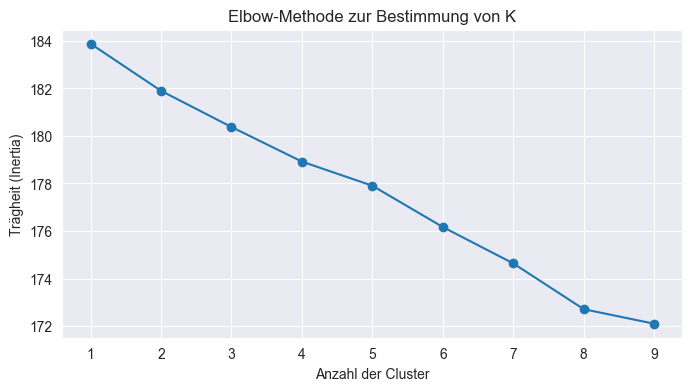

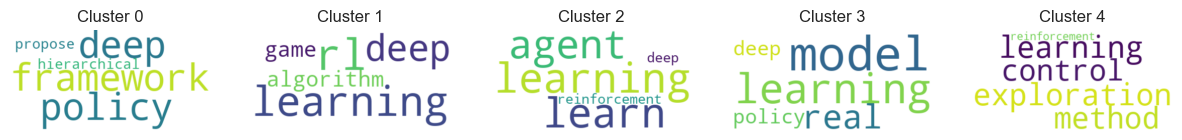

===================================================   2019   ===================================================


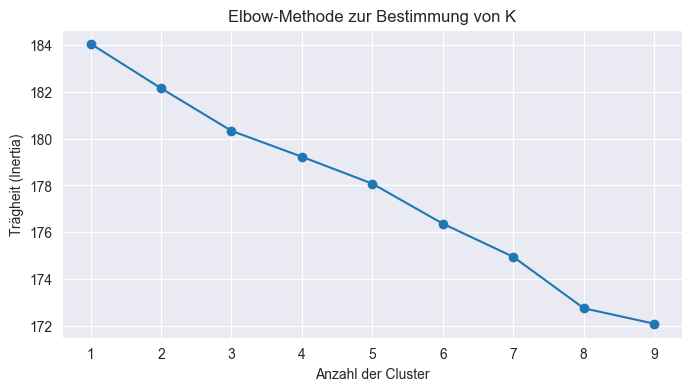

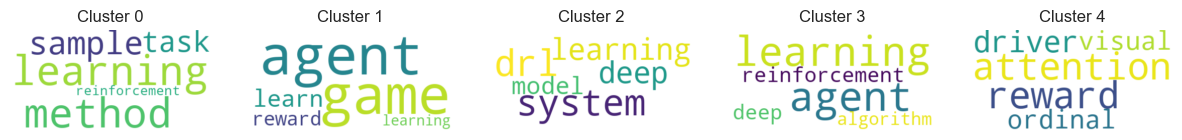

===================================================   2020   ===================================================


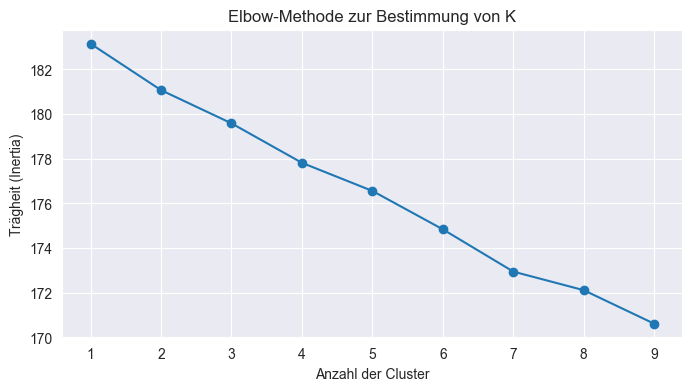

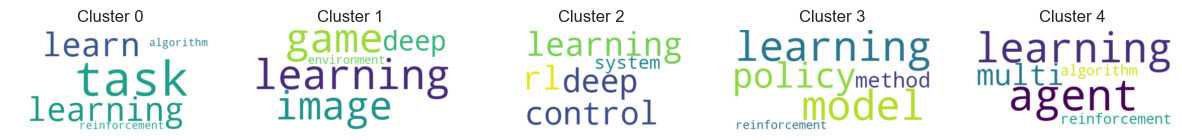

===================================================   2021   ===================================================


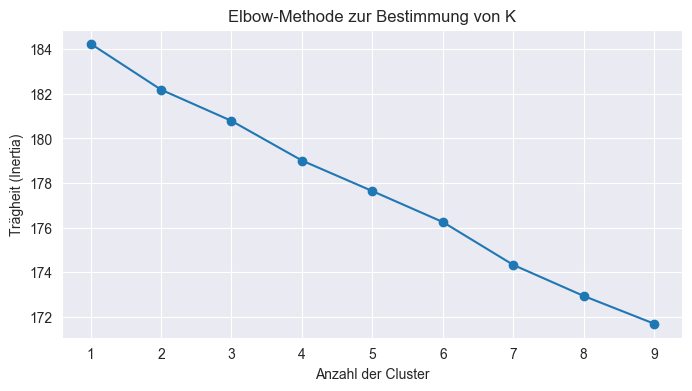

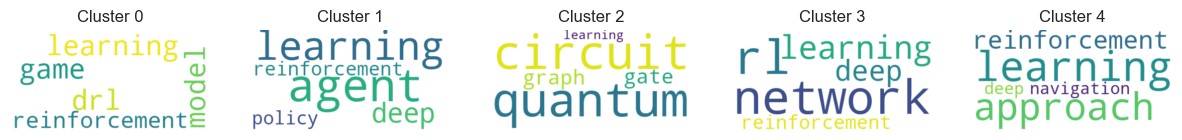

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from extraction import extract_data_from_arxiv
from preparation import prepare_data
from filtering import filter_abstract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

# Find best number clusters using elbow method
def find_optimal_k(x, max_k=10):
    distortions = []
    for k in range(1, max_k):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(x)
        distortions.append(km.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k), distortions, marker='o')
    plt.xlabel("Anzahl der Cluster")
    plt.ylabel("Trägheit (Inertia)")
    plt.title("Elbow-Methode zur Bestimmung von K")
    plt.show()

# Get keywords from the clusters
def get_cluster_keywords(x, clusters, features, top_n=5):
    cluster_keywords = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        words = np.array(x[cluster_indices].sum(axis=0)).flatten()
        most_significant_words = [features[i] for i in words.argsort()[-top_n:][::-1]]
        cluster_keywords[cluster] = ", ".join(most_significant_words)
    return cluster_keywords

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data and filter the abstract for stopwords
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=False)
df = filter_abstract(df)

for year in years:

    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year].copy()

    # Vectorize the abstract
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(year_filtered_df["Abstract"])

    # Add delimiter to separate the years in the output
    print(f"===================================================   {year}   ===================================================")

    # Apply Kmeans algorithm
    find_optimal_k(X, max_k=10)

    # Use elbow method to cluster
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    year_filtered_df["Cluster"] = kmeans.fit_predict(X)

    # Get names of clusters
    feature_names = vectorizer.get_feature_names_out()
    cluster_names = get_cluster_keywords(X.toarray(), year_filtered_df["Cluster"].values, feature_names)

    # Show results with cluster names
    year_filtered_df["Cluster Name"] = year_filtered_df["Cluster"].map(cluster_names)

    # Print wordcloud for the cluster names
    fig, axes = plt.subplots(1, len(cluster_names), figsize=(15, 5))
    for i, (cluster_id, keywords) in enumerate(cluster_names.items()):
        wordcloud = WordCloud(background_color="white").generate(keywords)
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].set_title(f"Cluster {cluster_id}")
        axes[i].axis("off")

    plt.show()

## Beschreibung der Ergebnisse der Textanalyse und Ausblick